In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import ortho_group
import os
import sys
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skimage.transform import AffineTransform, warp

from __future__ import print_function
#%matplotlib inline
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image, ImageDraw
import traceback

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128
# Size of z latent vector (i.e. size of generator input)
nz = 100

In [ ]:
def plot_gallery(list_images, h, w, n_row=3, n_col=6, flat_list = False):
    """Helper function to save a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row):
        for j in range(n_col):    
            plt.subplot(n_row, n_col, i * n_col + j + 1)
            if flat_list:
                plt.imshow(list_images[i*n_col + j].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            else:
                plt.imshow(list_images[j][i].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            plt.xticks(())
            plt.yticks(())

In [ ]:
def draw_figure(size=128, size_of_rect=60, pre_def = None, is_rect=True):
    if not pre_def is None:
        s = pre_def[0]
    else:
        s = int((np.random.sample(1)[0] * 0.8 + 0.2) * size_of_rect)
    
    a = np.array([s/2,  s/2], dtype=np.int)
    
    if not pre_def is None:
        c = np.array(pre_def[1:])
    else:
        c = np.random.randint(s/2, size - s/2, size=2)
    
    out = Image.new("L", (size, size), (0))
    d = ImageDraw.Draw(out)

    if is_rect:
        d.rectangle(np.concatenate([c-a, c+a]).tolist(), outline=(255), width=3)
    else:
        d.ellipse(  np.concatenate([c-a, c+a]).tolist(), outline=(255), width=3)
    
    return out, [s, c[0], c[1]]

In [ ]:
class ImageDataset(Dataset):
    
    def __init__(self, draw_function, lenght = 512, t=lambda x : x):
        super().__init__()
        self.lenght = lenght
        self.draw_function = draw_function
        self.t = t

        # imgs  = [None] * lenght
        # infos = [None] * lenght

        # for i in range(lenght):
        #     img, r = draw_function()

        #     imgs[i] = t(img)
        #     infos[i] = torch.Tensor(r)
        
        # self.imgs  = torch.vstack(imgs)
        # self.infos = torch.vstack(infos)

    def __getitem__(self, idx):
        # return self.imgs[idx], self.infos[idx]
        img, r = self.draw_function()

        return self.t(img), torch.Tensor(r)
    
    def __len__(self):
        # return len(self.data)
        return self.lenght

In [ ]:
t = transforms.Compose([transforms.GaussianBlur(11),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5)),
                       ])
rect_data = ImageDataset(lambda : draw_figure(is_rect=True ), lenght = 8192, t=t)
circ_data = ImageDataset(lambda : draw_figure(is_rect=False), lenght = 8192, t=t)

rect_val_data = ImageDataset(lambda : draw_figure(is_rect=True ), lenght = 512, t=t)
circ_val_data = ImageDataset(lambda : draw_figure(is_rect=False), lenght = 512, t=t)

rect_loader = torch.utils.data.DataLoader(rect_data, batch_size=256, num_workers=2)
circ_loader = torch.utils.data.DataLoader(circ_data, batch_size=256, num_workers=2)

rect_val_loader = torch.utils.data.DataLoader(rect_val_data, batch_size=512, num_workers=2)
circ_val_loader = torch.utils.data.DataLoader(circ_val_data, batch_size=512, num_workers=2)
print(len(rect_data), len(rect_loader))

rect_image_h = 64
rect_image_w = 64

8192 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


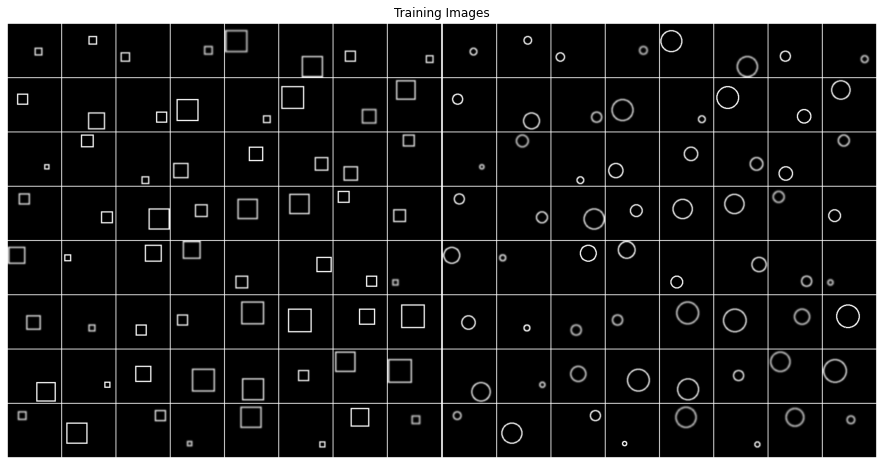

In [ ]:
rect_batch = next(iter(rect_loader))
circ_batch = next(iter(circ_loader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.hstack([np.transpose(vutils.make_grid(rect_batch[0][:64], padding=2, pad_value=255, normalize=True).cpu(),(1,2,0)),
                      np.transpose(vutils.make_grid(circ_batch[0][:64], padding=2, pad_value=255, normalize=True).cpu(),(1,2,0))]))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = self.main(input)
        return input.view(input.size(0), -1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 25, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        input = input.view((-1, 25, 1, 1))
        return self.main(input)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.BatchNorm1d(25),
            nn.Dropout(),
            nn.ReLU(True),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
ndf = 64
ngf = 64

netE = Encoder().cuda()
netE.apply(weights_init)
netD = [Decoder().cuda(), Decoder().cuda()]
netD[0].apply(weights_init); netD[1].apply(weights_init)
netC = Classifier().cuda()
netC.apply(weights_init)

Classifier(
  (main): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=25, out_features=25, bias=True)
    (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=25, out_features=25, bias=True)
    (9): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=25, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()


# Setup Adam optimizers for both G and D
optimizerE = optim.Adam(netE.parameters())
optimizerD = [optim.Adam(D.parameters()) for D in netD]
optimizerC = optim.Adam(netC.parameters())

In [ ]:
def train_all():
    netE.train(); netD[0].train(); netD[1].train(); netC.train(); 
    E_losses = []
    C_losses = []
    D1_losses = []
    D2_losses = []
    iters = 0
    num_epochs = 10

    print("Starting Training Loop...")
    # For each epoch
    try:
        for epoch in range(num_epochs):
            for _ in range(3):
                for i, (rect_data, circ_data) in enumerate(zip(rect_loader, circ_loader), 0):
                    ############################
                    # (1) Update C network: maximize log(C(E(z_0))) + log(1 - C(E(z_1)))
                    ###########################
                    ## Train with all-real batch
                    netC.zero_grad()
                    # Format batch
                    rect_data = rect_data[0].cuda()
                    circ_data = circ_data[0].cuda()
                    b_size = rect_data.size(0)
                    rect_label = torch.full((b_size,), 0, dtype=torch.float).cuda()
                    circ_label = torch.full((b_size,), 1, dtype=torch.float).cuda()
                    # Forward pass real batch through C
                    rect_emb_data = netE(rect_data)
                    circ_emb_data = netE(circ_data)

                    rect_output = netC(rect_emb_data.detach()).view(-1)
                    circ_output = netC(circ_emb_data.detach()).view(-1)
                    # Calculate loss on 0-domain batch
                    errC = criterion(rect_output, rect_label) + criterion(circ_output, circ_label)
                    # Calculate gradients for D in backward pass
                    errC.backward()
                    optimizerC.step()

                    # Save Losses for plotting later
                    C_losses.append(errC.item())

            # For each batch in the dataloader
            for i, (rect_data, circ_data) in enumerate(zip(rect_loader, circ_loader), 0):

                ############################
                # (1) Update C network: maximize log(C(E(z_0))) + log(1 - C(E(z_1)))
                ###########################
                ## Train with all-real batch
                netC.zero_grad()
                netD[0].zero_grad()
                netD[1].zero_grad()
                # Format batch
                rect_data = rect_data[0].cuda()
                circ_data = circ_data[0].cuda()
                b_size = rect_data.size(0)
                rect_label = torch.full((b_size,), 0, dtype=torch.float).cuda()
                circ_label = torch.full((b_size,), 1, dtype=torch.float).cuda()
                # Forward pass real batch through C
                rect_emb_data = netE(rect_data)
                circ_emb_data = netE(circ_data)

                rect_reconstructed = netD[0](rect_emb_data.detach())
                circ_reconstructed = netD[1](circ_emb_data.detach())

                rect_output = netC(rect_emb_data.detach()).view(-1)
                circ_output = netC(circ_emb_data.detach()).view(-1)

                errD1 = F.mse_loss(rect_reconstructed, rect_data)
                errD2 = F.mse_loss(circ_reconstructed, circ_data)
                # Calculate loss on 0-domain batch
                errC = criterion(rect_output, rect_label) + criterion(circ_output, circ_label)
                # Calculate gradients for D in backward pass
                (errC + errD1 + errD2).backward()
                optimizerC.step()
                optimizerD[0].step(); optimizerD[1].step()

                ############################
                # (2) Update E network: maximize log(D(G(z))) - MSE_reconstrunction
                ###########################
                netE.zero_grad()
                # Since we just updated C, perform another forward pass of all-fake batch through C
                rect_reconstructed = netD[0](rect_emb_data)
                circ_reconstructed = netD[1](circ_emb_data)

                rect_output = netC(rect_emb_data).view(-1)
                circ_output = netC(circ_emb_data).view(-1)

                # Calculate E's loss based on this output
                errD1 = F.mse_loss(rect_reconstructed, rect_data)
                errD2 = F.mse_loss(circ_reconstructed, circ_data)
                errE = criterion(rect_output, circ_label) + criterion(circ_output, rect_label) + errD1 + errD2
                # Calculate gradients for E, D
                errE.backward()
                # Update E, D
                optimizerE.step()

                # Output training stats
                if i % 50 == 0:
                    print('[%d/%d][%d/%d]\tLoss_C: %.4f\tLoss_E: %.4f\tLoss_D1: %.4f\tLoss_D2: %.4f\t'
                        % (epoch, num_epochs, i, len(rect_loader),
                            errC.item(), errE.item(), errD1.item(), errD2.item()))

                # Save Losses for plotting later
                E_losses.append(errE.item())
                C_losses.append(errC.item())
                D1_losses.append(errD1.item())
                D2_losses.append(errD2.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                #     with torch.no_grad():
                #         fake = netG(fixed_noise).detach().cpu()
                #     img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters += 1
    finally:
        return E_losses, C_losses, D1_losses, D2_losses

E_losses, C_losses, D1_losses, D2_losses = train_all()

Starting Training Loop...
[0/10][0/32]	Loss_C: 1.4118	Loss_E: 3.1629	Loss_D1: 0.9268	Loss_D2: 0.8501	
[1/10][0/32]	Loss_C: 1.3929	Loss_E: 1.5019	Loss_D1: 0.0632	Loss_D2: 0.0524	
[2/10][0/32]	Loss_C: 1.3864	Loss_E: 1.4993	Loss_D1: 0.0619	Loss_D2: 0.0514	
[3/10][0/32]	Loss_C: 1.3850	Loss_E: 1.4980	Loss_D1: 0.0611	Loss_D2: 0.0500	
[4/10][0/32]	Loss_C: 1.3854	Loss_E: 1.4981	Loss_D1: 0.0623	Loss_D2: 0.0507	
[5/10][0/32]	Loss_C: 1.3874	Loss_E: 1.4903	Loss_D1: 0.0562	Loss_D2: 0.0474	
[6/10][0/32]	Loss_C: 1.3871	Loss_E: 1.4845	Loss_D1: 0.0545	Loss_D2: 0.0417	
[7/10][0/32]	Loss_C: 1.3869	Loss_E: 1.4788	Loss_D1: 0.0508	Loss_D2: 0.0419	
[8/10][0/32]	Loss_C: 1.3873	Loss_E: 1.4705	Loss_D1: 0.0465	Loss_D2: 0.0382	
[9/10][0/32]	Loss_C: 1.3875	Loss_E: 1.4659	Loss_D1: 0.0429	Loss_D2: 0.0350	


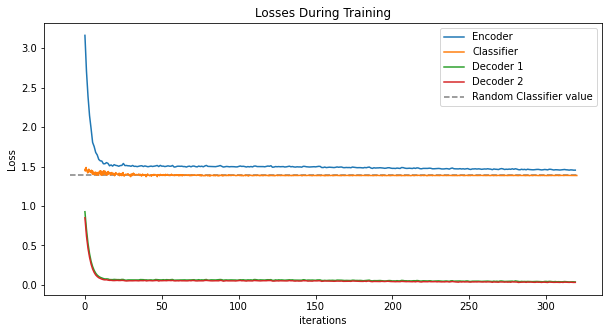

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Losses During Training")
plt.plot(E_losses,label="Encoder")
plt.plot(np.linspace(0, len(E_losses), len(C_losses)), C_losses,label="Classifier")
plt.plot(D1_losses,label="Decoder 1")
plt.plot(D2_losses,label="Decoder 2")
plt.hlines(1.3863, -10, len(E_losses), linestyles='--', alpha=0.5, label='Random Classifier value')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def get_emds():
    netE.eval(); netD[0].eval(); netD[1].eval(); netC.eval();
    rect_embs = []
    circ_embs = []
    netE.eval()
    with torch.no_grad():
        for i, (rect_data, circ_data) in enumerate(zip(rect_loader, circ_loader), 0):
            rect_data = rect_data[0].cuda()
            circ_data = circ_data[0].cuda()
            b_size = rect_data.size(0)
            # Forward pass real batch through C
            
            rect_embs.append(netE(rect_data).detach().cpu())
            circ_embs.append(netE(circ_data).detach().cpu())
    return rect_embs, circ_embs
rect_embs, circ_embs = get_emds()

In [ ]:
embs = torch.vstack(rect_embs + circ_embs).numpy()

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embs)

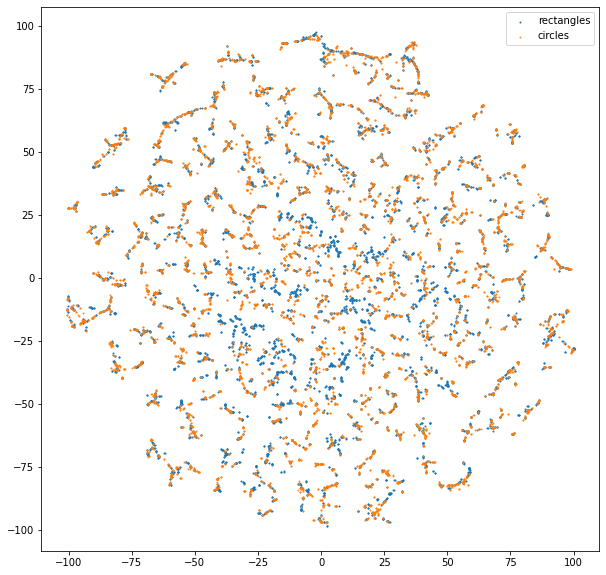

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:8192, 0], X_embedded[:8192, 1], label='rectangles', s=1, alpha=1)
plt.scatter(X_embedded[8192:, 0], X_embedded[8192:, 1], label='circles', s=1, alpha=0.8)
plt.legend()

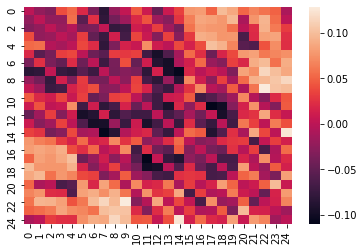

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

rect_corrMatrix = pd.DataFrame(torch.vstack(rect_embs).numpy()).corr()
circ_corrMatrix = pd.DataFrame(torch.vstack(circ_embs).numpy()).corr()
sns.heatmap(rect_corrMatrix - circ_corrMatrix)
plt.show()